# Intro

## Standard modules

In [1]:
import os, sys, pickle
import pathlib
import requests

In [2]:
import numpy as np

In [3]:
from tqdm.auto import tqdm, trange

In [4]:
from sentence_transformers import util

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.metrics import v_measure_score

In [8]:
import seaborn as sns

In [9]:
import pymannkendall as mk

In [10]:
from scipy.spatial.distance import cosine

In [11]:
import requests
import re
from bs4 import BeautifulSoup  # Per pulizia HTML nelle REST API

In [12]:
import datetime as dt

## Personal modules

In [13]:
from toolbox.updater import time_is_now

In [14]:
from file2text import file2text

In [15]:
from first_rough_cleaning import first_text_cleaner

In [16]:
from file_handler import *

In [17]:
from jina4lote import jina4lote

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [18]:
from tabulate import tabulate

## Folders

In [19]:
VECTOR_FOLDER='./NewProcessedData/vectors/'

In [20]:
BENCHMARK_FOLDER='./NewProcessedData/benchmarks/'

In [21]:
PCA_CENTR_VECTOR_FOLDER='./NewProcessedData/abtt5_vectors/'

## Sector helper

In [22]:
rtf_files=os.listdir('./rtf')
rtf_files.sort()

In [23]:
sec_helper={}
for file in rtf_files:
    splitted_name=file.split('_')
    if splitted_name[0].isnumeric():
        if splitted_name[0] not in sec_helper.keys():
            sec_helper[splitted_name[0].zfill(2)]=splitted_name[1]

In [24]:
sec_helper

{'10': 'Telecommunications',
 '11': 'Utilities',
 '01': 'Basic Materials',
 '02': 'Consumer Discretionary',
 '03': 'Consumer Staples',
 '04': 'Energy',
 '05': 'Financials',
 '06': 'Health Care',
 '07': 'Industrials',
 '08': 'Real Estate',
 '09': 'Technology'}

### Aggregated sectors

In [25]:
agg_secs={'A': {'name':'Consumer Goods', 'sectors':['02', '03']}, 
 'B':{'name':'Essential Infrastructure & Services', 'sectors':['08', '10', '11']}, 
 'C':{'name':'Production Sectors','sectors':['01', '04', '07']},
 'D':{'name':'Specialized Services','sectors':['05', '06', '09']}}

In [26]:
sec2agg_d={'01':'C', '02':'A', '03':'A', '04':'C', '05':'D', '06':'D', '07':'C', '08':'B', '09':'D', '10':'B', '11':'B'}

## SDG helper

In [27]:
sdg_helper={'01':'No Poverty', 
 '02': 'Zero hunger', 
 '03': 'Good health and well-being', 
 '04': 'Quality education',
 '05': 'Gender equality',
 '06': 'Clean water and sanitation',
 '07': 'Affordable and clean energy',
 '08': 'Decent work and economic growth',
 '09': 'Industry, Innovation, Technology and Infrastructure',
 '10': 'Reduced inequality',
 '11': 'Sustainable cities and communities',
 '12': 'Responsible consumption and production',
 '13': 'Climate action',
 '14': 'Life below water',
 '15': 'Life on land',
 '16': 'Peace, justice and strong institutions',
 '17': 'Partnerships for the goals'
}

## Load vectors

In [28]:
vecfiles=os.listdir(PCA_CENTR_VECTOR_FOLDER)

In [29]:
vecfiles.sort()

### Reports' vectors

In [30]:
reports_files=[vecfile for vecfile in vecfiles if vecfile[:4].isnumeric()]

In [31]:
reports_files.sort()

In [32]:
years, k_y=np.unique([rf[:4] for rf in reports_files], return_counts=True)

In [33]:
np.vstack((years, k_y)).T

array([['2015', '40'],
       ['2016', '44'],
       ['2017', '51'],
       ['2018', '56'],
       ['2019', '67'],
       ['2020', '69'],
       ['2021', '76'],
       ['2022', '80'],
       ['2023', '90']], dtype='<U21')

In [34]:
vectors=np.zeros(len(reports_files), dtype=[('year', 'i4'), ('sector', 'U2'), ('company', 'U100'), ('vector', object)])

In [35]:
for i_rf, reports_file in enumerate(reports_files):
    # info from the filename
    splitted_filename=reports_file.split('_')
    
    year=int(splitted_filename[0])
    sector=splitted_filename[1]
    if splitted_filename[-1]=='PLC.txt':
        company='_'.join(splitted_filename[2:-1])
    else:
        company='_'.join(splitted_filename[2:])
        company=company.replace('.txt', '')
    company=company.lower()
    # get the vector
    vector=np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+reports_file)
    
    # organize data
    vectors[i_rf]['year']=year
    vectors[i_rf]['sector']=sector
    vectors[i_rf]['company']=company
    vectors[i_rf]['vector']=vector

### Reports aggregated per sector per year

For each and sector I have an only entry, therefore the final vector has 

In [36]:
_tracks=np.unique(vectors[['year', 'sector']])
l_aggr_rep=len(_tracks)
l_aggr_rep

96

entries.

In [37]:
aggr_vectors=np.zeros(l_aggr_rep, dtype=[('year', 'i4'), ('sector', 'U2'), ('vector', object)])

In [38]:
for i_t, _track in enumerate(tqdm(_tracks)):
    year=_track[0]
    sector=_track[1]
    # select entries in vectors
    _mask=np.logical_and(vectors['year']==year, vectors['sector']==sector)
    _selection=vectors[_mask]
    # define te entries in aggr_vectors
    aggr_vectors[i_t]['year']=year
    aggr_vectors[i_t]['sector']=sector
    aggr_vectors[i_t]['vector']=np.mean(_selection['vector'])

  0%|          | 0/96 [00:00<?, ?it/s]

### Reports aggregated per aggregated sector per year

For each and sector I have an only entry, therefore the final vector has 

In [39]:
l_aggr_aggsec=4*len(years)
l_aggr_aggsec

36

entries.

In [40]:
aggsec_aggr_vectors=np.zeros(l_aggr_aggsec, dtype=[('year', 'i4'), ('agg_sec', 'U2'), ('vector', object)])

In [41]:
index=0
for year in tqdm(years):
    for i in range(4):
        _agg=chr(i+ord('A'))
        _agg_sectors=agg_secs[_agg]['sectors']
        # select entries in vectors
        _mask=np.logical_and(vectors['year']==year, np.isin(vectors['sector'],_agg_sectors))
        _selection=vectors[_mask]
        # define the entries in aggr_vectors
        aggsec_aggr_vectors[index]['year']=year
        aggsec_aggr_vectors[index]['agg_sec']=_agg
        aggsec_aggr_vectors[index]['vector']=np.mean(_selection['vector'])
        index+=1

  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_23862/503975990.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  _mask=np.logical_and(vectors['year']==year, np.isin(vectors['sector'],_agg_sectors))
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


### Witten's vector

In [42]:
wittenvecfile=[file for file in os.listdir(PCA_CENTR_VECTOR_FOLDER) if file.startswith('Witten') and file.endswith('.txt')][0]

In [43]:
wittenvec=np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+wittenvecfile)

### Goals' vectors

In [44]:
goalvecfiles=[vecfile for vecfile in vecfiles if vecfile.startswith('Goal')]

In [45]:
goalvecfiles.sort()

In [46]:
goalvecfiles

['Goal-01-Fast-Facts.txt',
 'Goal-02-Fast-Facts.txt',
 'Goal-03-Fast-Facts.txt',
 'Goal-04-Fast-Facts.txt',
 'Goal-05-Fast-Facts.txt',
 'Goal-06-Fast-Facts.txt',
 'Goal-07-Fast-Facts.txt',
 'Goal-08-Fast-Facts.txt',
 'Goal-09-Fast-Facts.txt',
 'Goal-10-Fast-Facts.txt',
 'Goal-11_Fast-Facts.txt',
 'Goal-12_Fast-Facts.txt',
 'Goal-13_Fast-Facts.txt',
 'Goal-14_Fast-Facts.txt',
 'Goal-15-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt',
 'Goal-Fast-Facts.txt']

In [47]:
goalvecs=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles]

### Wikipedia's vectors

In [48]:
wikivecfiles=[vecfile for vecfile in vecfiles if vecfile.startswith('wiki')]

In [49]:
wikivecfiles.sort()

In [50]:
len(wikivecfiles)

4001

In [51]:
wikivecs=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+wikivecfile) for wikivecfile in wikivecfiles]

## FDR

In [52]:
def fdr_th(p_vals, alpha):
    _aux=np.sort(p_vals)
    fdr_ths=np.arange(1, 1+len(_aux))*alpha/len(_aux)
    fdr_mask=_aux<=fdr_ths
    if np.sum(fdr_mask)>0:
        return fdr_ths[fdr_mask][-1]
    else:
        return 0.

# Internal similarity

## The benchmark

In [53]:
years=years.astype('i4')

In [54]:
sdgs=list(sdg_helper.keys())

In [55]:
wiki_bench_sdg=np.zeros(len(sdg_helper.keys()), dtype=[('cos_sim', object)])

In [56]:
for i_gv, goalvec in enumerate(tqdm(goalvecs[:17])):
    wiki_bench_sdg[i_gv]['cos_sim']=np.zeros(len(wikivecs))
    for i_w, wikivec in enumerate(tqdm(wikivecs, leave=False)):
        wiki_bench_sdg[i_gv]['cos_sim'][i_w]=float(util.cos_sim(wikivec, goalvec))

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

### Check: internal similarity among SDGs

In [57]:
cos_sdgs_mat=np.ones((17, 17), dtype=float)
for i_s, sdg_0 in enumerate(sdgs):
    for j_s in range(i_s+1, len(sdgs)):
            cos_sdgs_mat[i_s, j_s]=float(util.cos_sim(goalvecs[i_s], goalvecs[j_s]))
            cos_sdgs_mat[j_s, i_s]=cos_sdgs_mat[i_s, j_s]

In [58]:
social_sdgs=['01','02','03','04','05','10','16','17']
economic_sdgs=['07','08','09','11','12']
environmental_sdgs=['06','13','14','15']

In [59]:
new_order_memb=[0,0,0,0,0,2,1,1,1,0,1,1,2,2,2,0,0]

In [63]:
new_order=np.array([0,1,2,3,4,9,15,16,6,7,8,10,11,5,12,13,14])

In [64]:
assert len(new_order_memb)==len(new_order)

In [65]:
csmat_reordered=cos_sdgs_mat.copy()

In [66]:
csmat_reordered=csmat_reordered[new_order]
csmat_reordered=(csmat_reordered.T[new_order]).T

In [69]:
sdg_labels=['SDG '+sdg for sdg in sdg_helper.keys()]

In [71]:
n=len(sdg_labels)

In [72]:
asdgs_labels_reordered=[sdg_labels[no] for no in new_order]

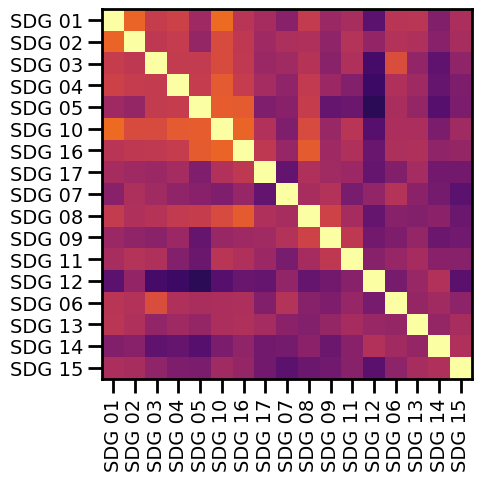

In [73]:
plt.imshow(csmat_reordered, cmap='inferno', vmin=0, vmax=1)
plt.xticks(np.arange(n), labels=asdgs_labels_reordered, rotation=90)
plt.yticks(np.arange(n), labels=asdgs_labels_reordered)
plt.grid(False)
plt.show()

### Hierarchical Clustering, by ChatGPT

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import pandas as pd

In [75]:
n=len(sdg_labels)

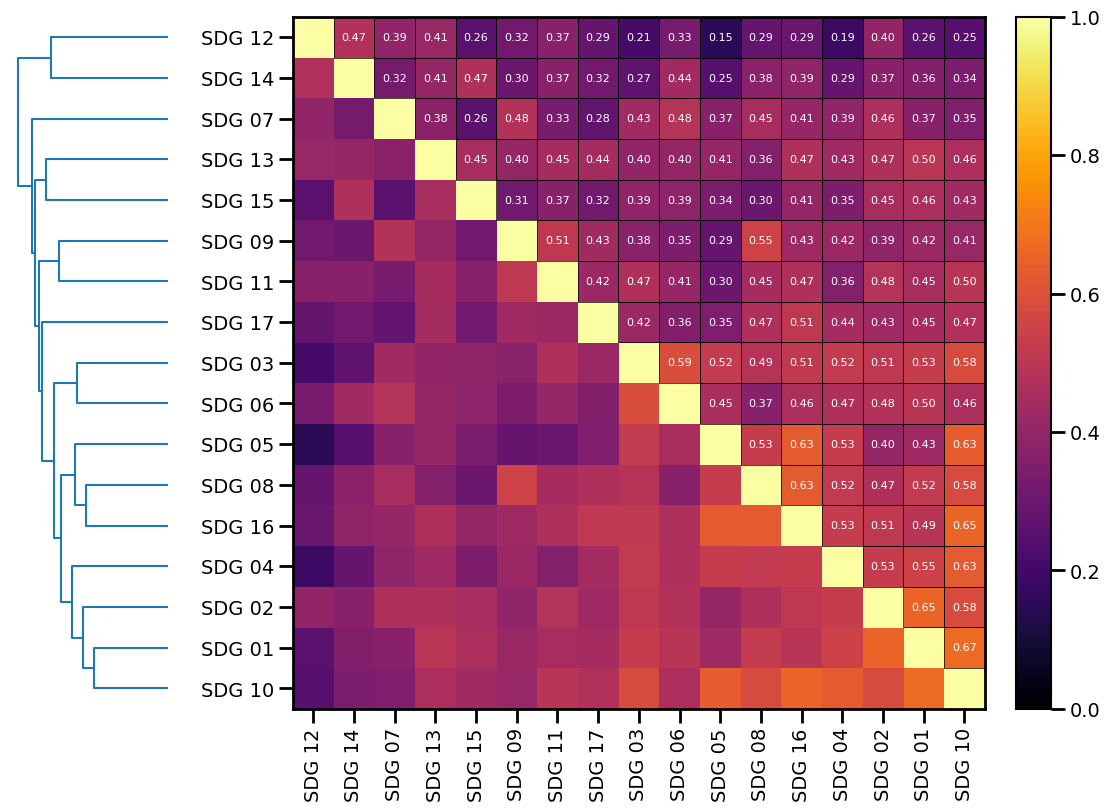

In [77]:
# === 2. Clustering === #
dist_condensed = squareform(1 - cos_sdgs_mat)
Z = linkage(dist_condensed, method='average')
dendro = dendrogram(Z, no_plot=True)
reorder = dendro['leaves']
sim_matrix_reordered = cos_sdgs_mat[np.ix_(reorder, reorder)]
labels_reordered = [sdg_labels[i] for i in reorder]
cluster_labels = fcluster(Z, t=5, criterion='maxclust')
cluster_labels_reordered = [cluster_labels[i] for i in reorder]

# === 3. Blocchi (cluster) === #
blocks = []
prev = cluster_labels_reordered[0]
start = 0
for i, val in enumerate(cluster_labels_reordered):
    if val != prev:
        blocks.append((start, i, prev))
        start = i
        prev = val
blocks.append((start, len(cluster_labels_reordered), prev))

# === 4. Plot: dendrogramma + heatmap === #

# Layout: 1 riga, 2 colonne (dendro a sinistra, heatmap a destra)
fig = plt.figure(figsize=(11, 8), constrained_layout=True)
gs = fig.add_gridspec(1, 2, width_ratios=[1, 5], wspace=0.05)

# --- 4.1 Dendrogramma a sinistra --- #
ax_dendro = fig.add_subplot(gs[0])
ax_dendro.set_facecolor('none')
dendrogram(Z, orientation='left', labels=[sdg_labels[i] for i in reorder], ax=ax_dendro, color_threshold=0)
ax_dendro.invert_yaxis()
ax_dendro.set_xticks([])
ax_dendro.set_yticks([])
for spine in ax_dendro.spines.values():
    spine.set_visible(False)

# --- 4.2 Heatmap --- #
ax = fig.add_subplot(gs[1])


# Heatmap
im = ax.imshow(sim_matrix_reordered, cmap='inferno', vmin=0, vmax=1)


# Etichette
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(labels_reordered, rotation=90)
ax.set_yticklabels(labels_reordered)

# Annotazioni numeriche
for i in range(n):
    for j in range(i+1, n):
        val = sim_matrix_reordered[i, j]
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)

# Riquadri neri su ogni cella nel triangolo superiore
for i in range(n):
    for j in range(i+1, n):
        rect = patches.Rectangle((j - 0.5, i - 0.5), 1.0, 1.0,
                                 linewidth=0.5, edgecolor='black', facecolor='none')
        ax.add_patch(rect)

# Rettangoli rossi attorno ai blocchi
#for start, end, cluster_id in blocks:
#    width = end - start
#    rect = patches.Rectangle((start - 0.5, start - 0.5), width, width,
#                             linewidth=2, edgecolor='red', facecolor='none')
#    ax.add_patch(rect)
ax.grid(False)
# Colorbar con bordo nero
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1.5)


plt.savefig('./NewPlots/internal_similarity_SDGs.png', dpi=300)
plt.show()

### All together?

In [78]:
n=len(sdg_labels)

In [79]:
# === 2. Clustering === #
dist_condensed = squareform(1 - cos_sdgs_mat)
Z = linkage(dist_condensed, method='average')
dendro = dendrogram(Z, no_plot=True)
reorder = dendro['leaves']
sim_matrix_reordered = cos_sdgs_mat[np.ix_(reorder, reorder)]
labels_reordered = [sdg_labels[i] for i in reorder]
cluster_labels = fcluster(Z, t=5, criterion='maxclust')
cluster_labels_reordered = [cluster_labels[i] for i in reorder]

In [80]:
# Ordering according to SDGs' dimensions
new_order=np.flip(np.array([0,1,2,3,4,9,15,16,6,7,8,10,11,5,12,13,14]))

csmat_reordered=cos_sdgs_mat.copy()
csmat_reordered=csmat_reordered[new_order]
csmat_reordered=(csmat_reordered.T[new_order]).T

asdgs_labels_reordered=[sdg_labels[no] for no in new_order]

In [81]:
# === 3. Blocchi (cluster) === #
blocks = []
prev = new_order[0]
start = 0
for i, val in enumerate(new_order):
    if val > prev:
        blocks.append((start, i, prev))
        start = i
    prev = val
blocks.append((start, len(cluster_labels_reordered), prev))

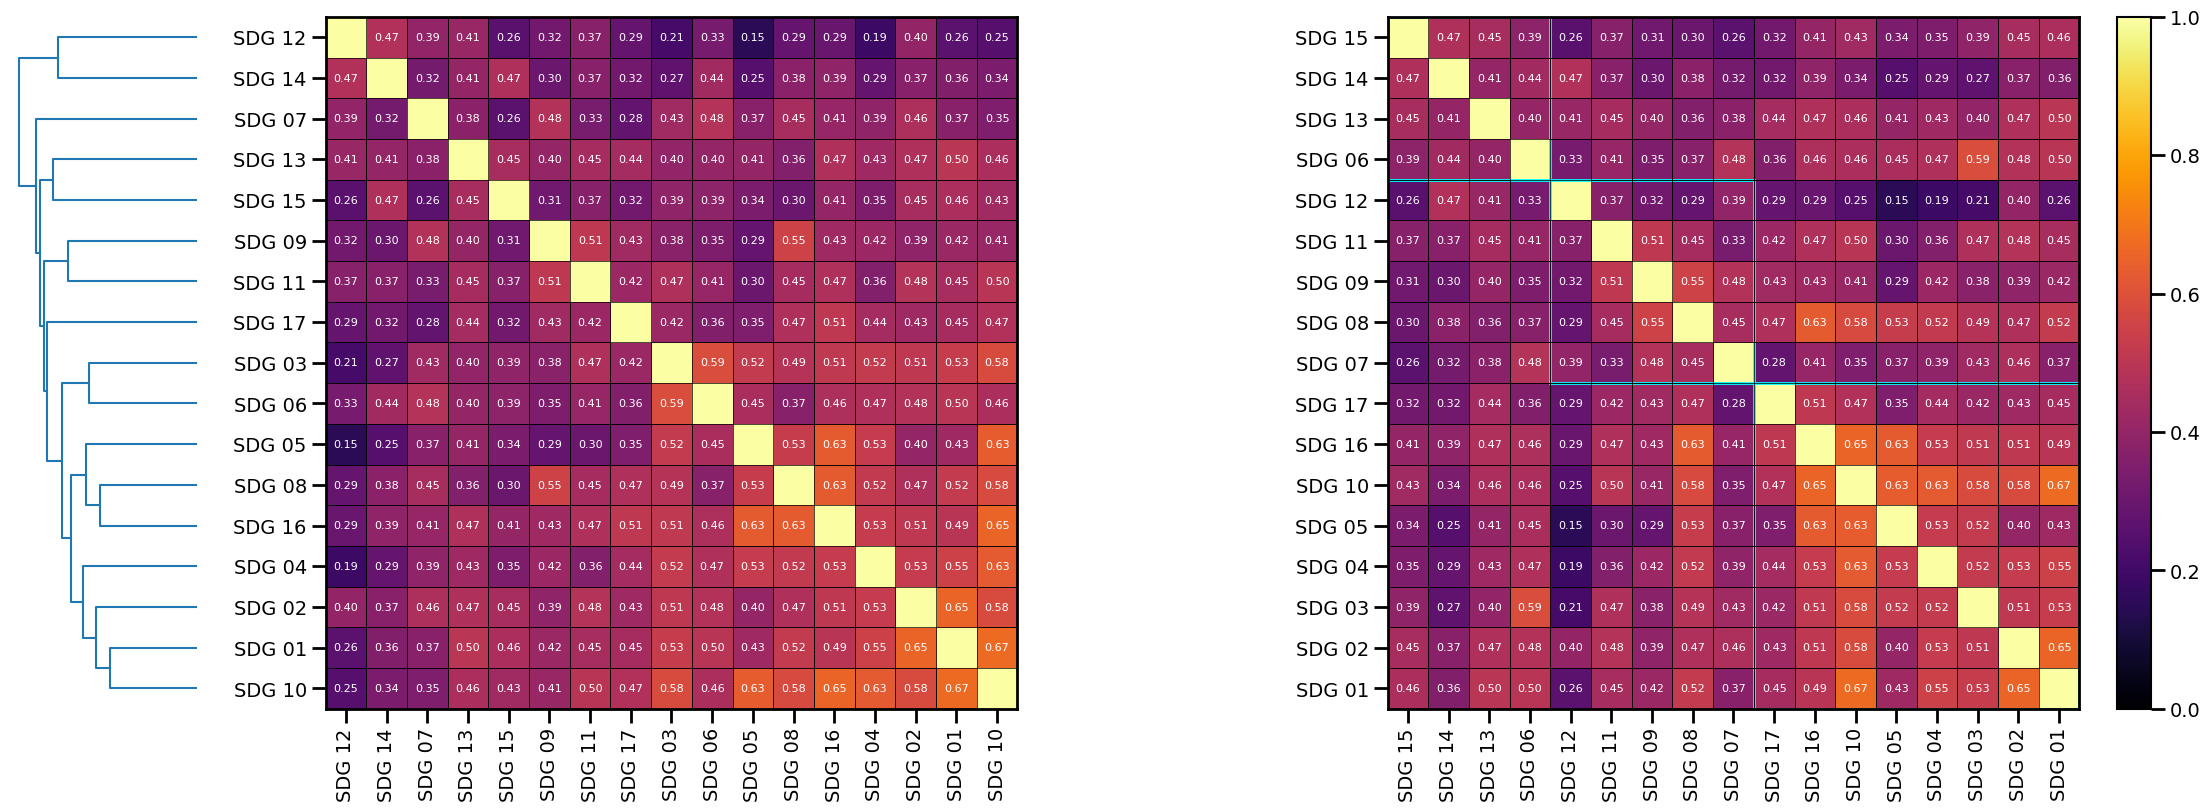

In [83]:
# === 4. Plot: dendrogramma + heatmap === #

# Layout: 1 riga, 2 colonne (dendro a sinistra, heatmap a destra)
fig = plt.figure(figsize=(22, 8), constrained_layout=True)
gs = fig.add_gridspec(1, 3, width_ratios=[1, 5, 5], wspace=0.01)

# --- 4.1 Dendrogramma a sinistra --- #
ax_dendro = fig.add_subplot(gs[0])
ax_dendro.set_facecolor('none')
dendrogram(Z, orientation='left', labels=[sdg_labels[i] for i in reorder], ax=ax_dendro, color_threshold=0)
ax_dendro.invert_yaxis()
ax_dendro.set_xticks([])
ax_dendro.set_yticks([])
for spine in ax_dendro.spines.values():
    spine.set_visible(False)

# --- 4.2 Heatmaps --- #
ax_im0 = fig.add_subplot(gs[1])
ax_im1 = fig.add_subplot(gs[2])
# Heatmaps
ax_im0.imshow(sim_matrix_reordered, cmap='inferno', vmin=0, vmax=1)
ax_im1.imshow(csmat_reordered, cmap='inferno', vmin=0, vmax=1)

# Rettangoli rossi attorno ai blocchi di ax_im1
for start, end, cluster_id in blocks:
    width = end - start
    rect = patches.Rectangle((start - 0.5, start - 0.5), width, width,
                             linewidth=2, edgecolor='cyan', facecolor='none')
    ax_im1.add_patch(rect)



labels=[labels_reordered, asdgs_labels_reordered]
mats=[sim_matrix_reordered, csmat_reordered]
# Etichette
for i_ax, ax in enumerate([ax_im0, ax_im1]):
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(labels[i_ax], rotation=90)
    ax.set_yticklabels(labels[i_ax])

    # Annotazioni numeriche
    for i in range(n):
        for j in range(i+1, n):
            val = mats[i_ax][i, j]
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)
            ax.text(i, j, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)

            # Riquadri neri su ogni cella: triangolo superiore
            rect = patches.Rectangle((j - 0.5, i - 0.5), 1.0, 1.0,
                                 linewidth=0.5, edgecolor='black', facecolor='none')
            ax.add_patch(rect)
            
            # Riquadri neri su ogni cella: triangolo inferiore
            rect = patches.Rectangle((i - 0.5, j - 0.5), 1.0, 1.0,
                                 linewidth=0.5, edgecolor='black', facecolor='none')
            ax.add_patch(rect)
            
            
    ax.grid(False)
# Colorbar con bordo nero
cbar = plt.colorbar(im, ax=ax_im1, fraction=0.046, pad=0.04)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1.5)


plt.savefig('./NewPlots/internal_similarity_SDGs_all.png', dpi=300)
plt.show()

### Validating p-values

In [84]:
p_vals=np.zeros(n*(n-1), dtype=[('node_0', int), ('node_1', int), ('p_value', float)])
counter=0
for i_i_row, i_row in enumerate(cos_sdgs_mat):
    for j, entry in enumerate(i_row):
        if j!=i_i_row:
            p_vals[counter]['node_0']=i_i_row
            p_vals[counter]['node_1']=j
            p_vals[counter]['p_value']=np.sum(wiki_bench_sdg[i_i_row]['cos_sim']>=entry)/4001
            counter+=1

In [85]:
fdr_th_sdgs=fdr_th(p_vals['p_value'], alpha=0.05)

In [86]:
np.sum(p_vals['p_value']<=fdr_th_sdgs)/n/(n-1)

0.9595588235294118

#### Alpha-matrix 1

In [161]:
# Ordering according to SDGs' dimensions
new_order=np.flip(np.array([0,1,2,3,4,9,15,16,6,7,8,10,11,5,12,13,14]))

csmat_reordered=cos_sdgs_mat.copy()
csmat_reordered=csmat_reordered[new_order]
csmat_reordered=(csmat_reordered.T[new_order]).T

asdgs_labels_reordered=[sdg_labels[no] for no in new_order]

In [174]:
find_me_1=np.argsort(new_order)

In [175]:
val_pvals=p_vals[p_vals['p_value']<=fdr_th_sdgs].copy()
ordered_vpv=np.zeros(len(val_pvals),dtype=[('node_0', int), ('node_1', int)])
counter=0
for val_pval in val_pvals:
    node_0=find_me_1[val_pval['node_0']]
    node_1=find_me_1[val_pval['node_1']]
    ordered_vpv[counter]['node_0']=node_0
    ordered_vpv[counter]['node_1']=node_1
    counter+=1

In [176]:
alpha_matrix_1=np.ones((n,n))*.2
for _ in range(len(ordered_vpv)):
    i=ordered_vpv[_]['node_0']
    j=ordered_vpv[_]['node_1']
    alpha_matrix_1[i, j]=1.

#### Alpha-matrix 0

In [146]:
# === 2. Clustering === #
dist_condensed = squareform(1 - cos_sdgs_mat)
Z = linkage(dist_condensed, method='average')
dendro = dendrogram(Z, no_plot=True)
reorder = dendro['leaves']
sim_matrix_reordered = cos_sdgs_mat[np.ix_(reorder, reorder)]
labels_reordered = [sdg_labels[i] for i in reorder]
cluster_labels = fcluster(Z, t=5, criterion='maxclust')
cluster_labels_reordered = [cluster_labels[i] for i in reorder]

In [178]:
find_me_0=np.argsort(reorder)

In [179]:
val_pvals=p_vals[p_vals['p_value']<=fdr_th_sdgs].copy()
ordered_vpv=np.zeros(len(val_pvals),dtype=[('node_0', int), ('node_1', int)])
counter=0
for val_pval in val_pvals:
    node_0=find_me_0[val_pval['node_0']]
    node_1=find_me_0[val_pval['node_1']]
    ordered_vpv[counter]['node_0']=node_0
    ordered_vpv[counter]['node_1']=node_1
    counter+=1

In [180]:
alpha_matrix_0=np.ones((n,n))*.2
for _ in range(len(ordered_vpv)):
    i=ordered_vpv[_]['node_0']
    j=ordered_vpv[_]['node_1']
    alpha_matrix_0[i, j]=1.

#### All together, again

In [181]:
# === 3. Blocchi (cluster) === #
blocks_1 = []
prev = new_order[0]
start = 0
for i, val in enumerate(new_order):
    if val > prev:
        blocks_1.append((start, i, prev))
        start = i
    prev = val
blocks_1.append((start, len(new_order), prev))

blocks_0 = []
prev = cluster_labels_reordered[0]
start = 0
for i, val in enumerate(cluster_labels_reordered):
    if val > prev:
        blocks_0.append((start, i, prev))
        start = i
    prev = val
blocks_0.append((start, len(cluster_labels_reordered), prev))

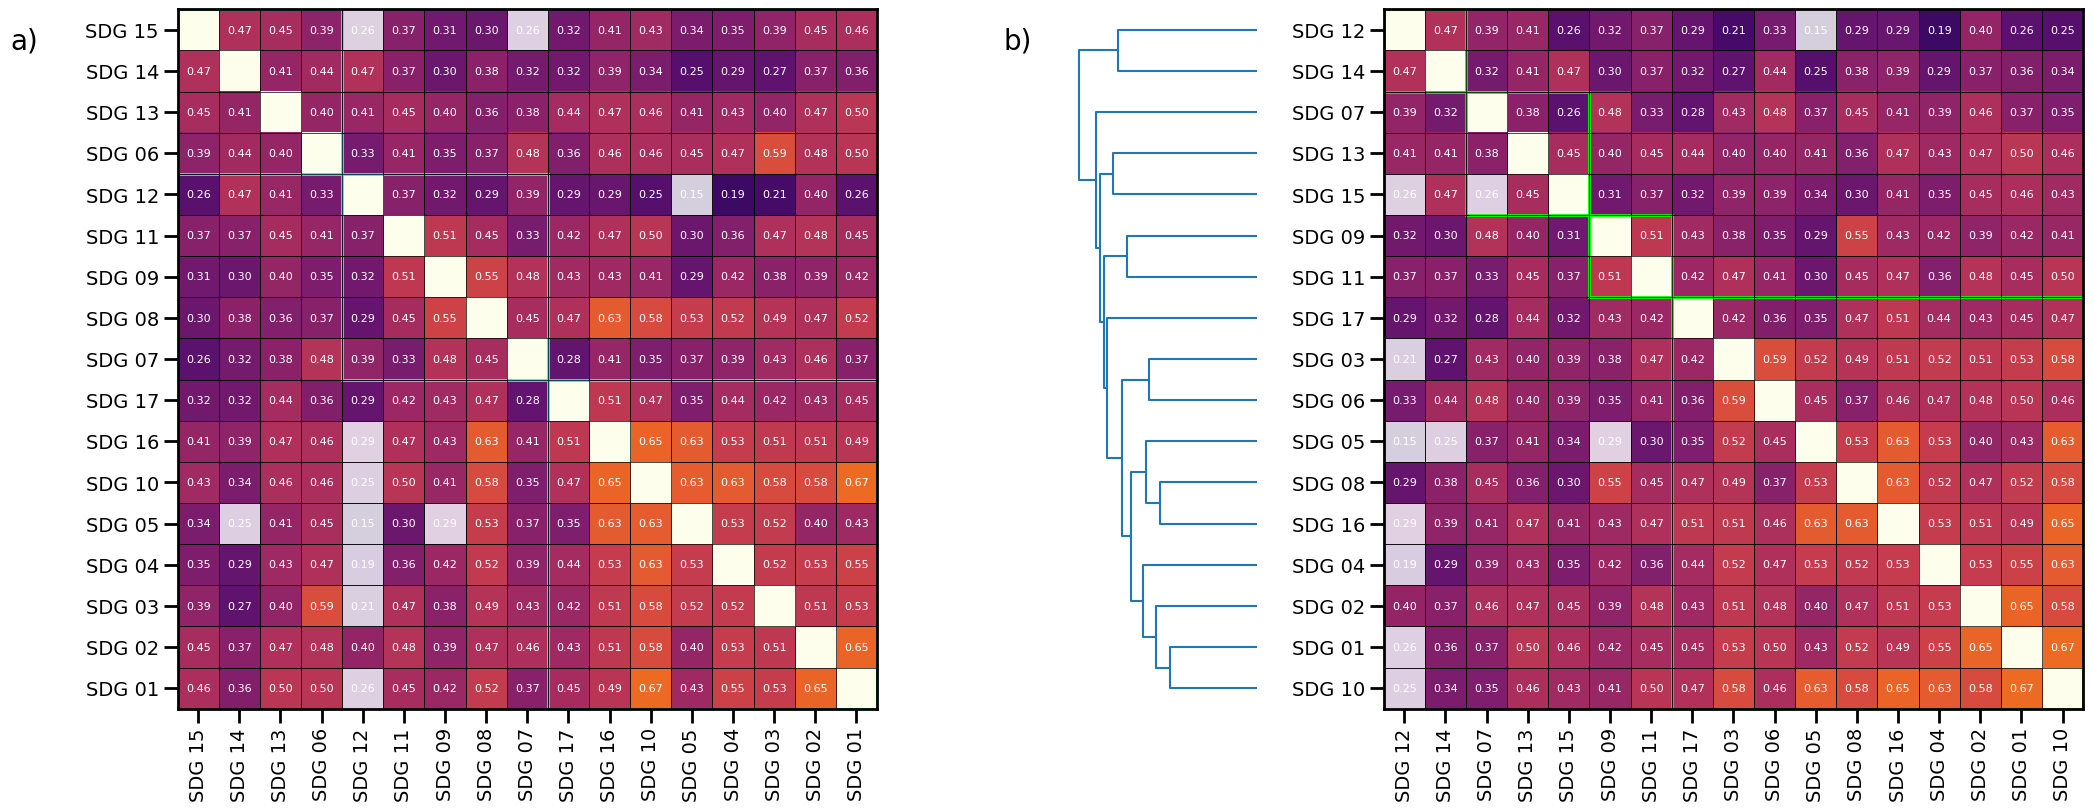

In [204]:
# === 4. Plot: dendrogramma + heatmap === #

# Layout: 1 riga, 2 colonne (dendro a sinistra, heatmap a destra)
fig = plt.figure(figsize=(22, 8), constrained_layout=True)
gs = fig.add_gridspec(1, 3, width_ratios=[5, 1, 5], wspace=0.01)

# --- 4.1 Dendrogramma a sinistra --- #
ax_dendro = fig.add_subplot(gs[1])
ax_dendro.set_facecolor('none')
dendrogram(Z, orientation='left', labels=[sdg_labels[i] for i in reorder], ax=ax_dendro, color_threshold=0)
ax_dendro.invert_yaxis()
ax_dendro.set_xticks([])
ax_dendro.set_yticks([])
for spine in ax_dendro.spines.values():
    spine.set_visible(False)

# --- 4.2 Heatmaps --- #
ax_im0 = fig.add_subplot(gs[2])
ax_im1 = fig.add_subplot(gs[0])
# Heatmaps
ax_im0.imshow(sim_matrix_reordered, cmap='inferno', vmin=0, vmax=1, alpha=alpha_matrix_0)
ax_im1.imshow(csmat_reordered, cmap='inferno', vmin=0, vmax=1, alpha=alpha_matrix_1)

# Rettangoli cyan attorno ai blocchi di ax_im1
for start, end, cluster_id in blocks_1:
    width = end - start
    rect = patches.Rectangle((start - 0.5, start - 0.5), width, width,
                             linewidth=2, edgecolor='cyan', facecolor='none')
    ax_im1.add_patch(rect)

# Rettangoli lime attorno ai blocchi di ax_im0
for start, end, cluster_id in blocks_0:
    width = end - start
    rect = patches.Rectangle((start - 0.5, start - 0.5), width, width,
                             linewidth=2, edgecolor='lime', facecolor='none')
    ax_im0.add_patch(rect)

    


labels=[labels_reordered, asdgs_labels_reordered]
mats=[sim_matrix_reordered, csmat_reordered]
# Etichette
for i_ax, ax in enumerate([ax_im0, ax_im1]):
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(labels[i_ax], rotation=90)
    ax.set_yticklabels(labels[i_ax])

    # Annotazioni numeriche
    for i in range(n):
        for j in range(i+1, n):
            val = mats[i_ax][i, j]
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)
            ax.text(i, j, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)
            #if i_ax==0:
            #    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)
            #    ax.text(i, j, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)
            #else:
            #    if j in ordered_vpv[ordered_vpv['node_0']==i]['node_1']:
            #        ax.text(j, i, f"{val:.2f}*", ha='center', va='center', color='white', fontsize=8)
            #    else:
            #        ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)
            #        
            #    if i in ordered_vpv[ordered_vpv['node_0']==j]['node_1']:
            #        ax.text(i, j, f"{val:.2f}*", ha='center', va='center', color='white', fontsize=8)
            #    else:
            #        ax.text(i, j, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)
                

            # Riquadri neri su ogni cella: triangolo superiore
            rect = patches.Rectangle((j - 0.5, i - 0.5), 1.0, 1.0,
                                 linewidth=0.5, edgecolor='black', facecolor='none')
            ax.add_patch(rect)
            
            # Riquadri neri su ogni cella: triangolo inferiore
            rect = patches.Rectangle((i - 0.5, j - 0.5), 1.0, 1.0,
                                 linewidth=0.5, edgecolor='black', facecolor='none')
            ax.add_patch(rect)
            
            
    ax.grid(False)
# Colorbar con bordo nero
#cbar = plt.colorbar(im, ax=ax_im1, fraction=0.046, pad=0.04)
#cbar.outline.set_edgecolor('black')
#cbar.outline.set_linewidth(1.5)

# nome dei panel
ax_dendro.text(-.2, 0.975, 'b)', transform=ax_dendro.transAxes,
            fontsize=20, va='top', ha='right')
ax_im1.text(-0.2, 0.975, 'a)', transform=ax_im1.transAxes,
            fontsize=20, va='top', ha='right')

plt.savefig('./NewPlots/internal_similarity_SDGs_all_w_valid.png', dpi=300)
plt.show()

In [200]:
v_measure_score(new_order_memb, cluster_labels)

0.522147836132708

In [209]:
np.max(csmat_reordered-np.diag(np.diag(csmat_reordered)))

0.6693020872331104

In [211]:
np.min(csmat_reordered)

0.148494001224647

#### Only macro sectors

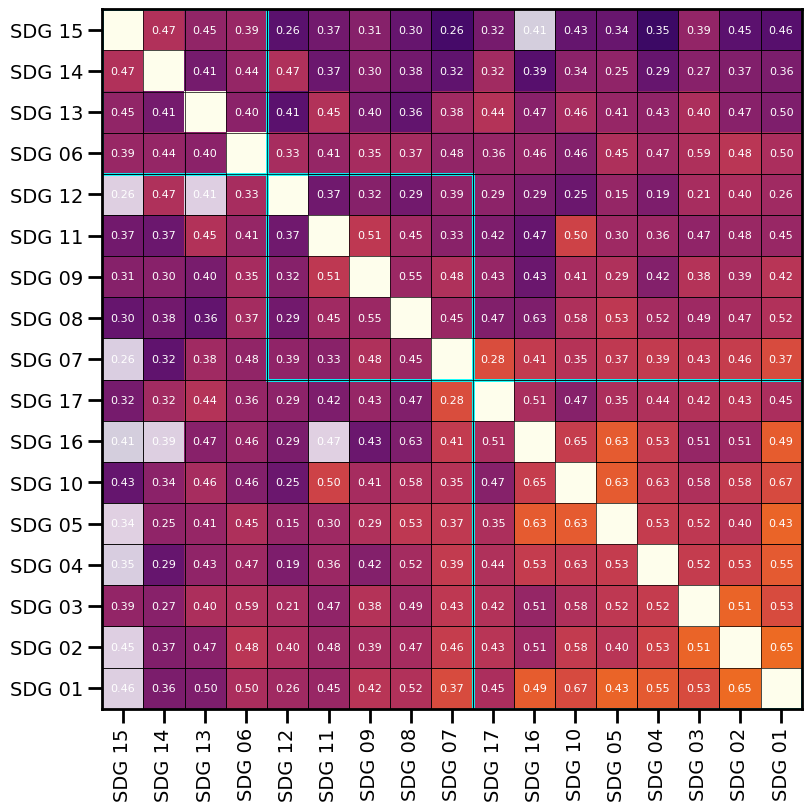

In [216]:
fig = plt.figure(figsize=(11, 8), constrained_layout=True)
plt.imshow(sim_matrix_reordered, cmap='inferno', vmin=0, vmax=1, alpha=alpha_matrix_0)
# Rettangoli lime attorno ai blocchi di ax_im0

ax = plt.gca()

for start, end, cluster_id in blocks_1:
    width = end - start
    rect = patches.Rectangle((start - 0.5, start - 0.5), width, width,
                             linewidth=2, edgecolor='cyan', facecolor='none')
    ax.add_patch(rect)

# Etichette

plt.xticks(np.arange(n), labels=asdgs_labels_reordered, rotation=90)
plt.yticks(np.arange(n), labels=asdgs_labels_reordered)

# Annotazioni numeriche
for i in range(n):
    for j in range(i+1, n):
        val = csmat_reordered[i, j]
        plt.text(j, i, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)
        plt.text(i, j, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)
            
        # Riquadri neri su ogni cella: triangolo superiore
        rect = patches.Rectangle((j - 0.5, i - 0.5), 1.0, 1.0,
                                 linewidth=0.5, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
            
        # Riquadri neri su ogni cella: triangolo inferiore
        rect = patches.Rectangle((i - 0.5, j - 0.5), 1.0, 1.0,
                                 linewidth=0.5, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
            
            
plt.grid(False)

plt.savefig('./NewPlots/internal_similarity_agg_SDGs_w_valid.png', dpi=300)
plt.show()